In [2]:
import joblib
from sklearn.metrics import accuracy_score
import numpy as np
from facenet_pytorch import fixed_image_standardization
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
from retinaface import RetinaFace
import torch
import pickle
import os
from sklearn.metrics import accuracy_score
from facenet_pytorch import InceptionResnetV1
device="mps" if torch.backends.mps.is_available() else "cpu"
print(f"device being used is {device}")
model = InceptionResnetV1(pretrained='vggface2', dropout_prob=0.5, device=device).eval()
model

device being used is mps


InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [3]:
with open('data/class_list.pkl', 'rb') as file:
    ClassList = pickle.load(file)
    
def name_from_index(i, ClassList=ClassList):
    reversed_dict = {v: k for k, v in ClassList.items()}
    if isinstance(i, np.ndarray):  # Check if i is a NumPy array
        names = [reversed_dict.get(idx.item(), None) for idx in i]
        return names
    else:
        return reversed_dict.get(i, None)
standard_transform = transforms.Compose([
                                np.float32,
                                transforms.ToTensor(),
                                fixed_image_standardization,
                                transforms.Resize([224, 224],antialias=None )
])

In [6]:
SVM_PATH = os.path.join("data", 'svm50.sav')
clf = joblib.load(SVM_PATH)
DATA_PATH="data"
TRAIN_EMBEDS = os.path.join(DATA_PATH, 'Embedings/trainEmbeds.npz')
TEST_EMBEDS = os.path.join(DATA_PATH, 'Embedings/testEmbeds.npz')
trainEmbeds, trainLabels = np.load(TRAIN_EMBEDS, allow_pickle=True).values()
testEmbeds, testLabels = np.load(TEST_EMBEDS, allow_pickle=True).values()
X_test, y_test = np.copy(testEmbeds), np.array([name_from_index(label) for label in testLabels])
test_acc = accuracy_score(clf.predict(X_test), y_test)
print(f'Accuracy score on test data: {test_acc}')

Accuracy score on test data: 0.8865979381443299


In [7]:
predModel=torch.load("data/models/predictFacesModelAcc90.7.pth")

In [8]:
import torch.nn as nn
import torch.optim as optim
X = torch.tensor(trainEmbeds, dtype=torch.float32).to(device)
y = torch.tensor(trainLabels, dtype=torch.long).to(device)
X_test=torch.tensor(testEmbeds,dtype=torch.float32).to(device)
y_test=torch.tensor(testLabels,dtype=torch.long).to(device)

In [12]:
from torch import nn
class SVM(nn.Module):
    def __init__(self):
        super(SVM, self).__init__()
        self.fc = nn.Linear(X.shape[1], len(ClassList))

    def forward(self, x):
        return self.fc(x)
predict = SVM().to(device)
predict.load_state_dict(torch.load(f="data/models/predictFacesModelAcc100.pth"))
predict.eval()

SVM(
  (fc): Linear(in_features=512, out_features=7, bias=True)
)

# For check an individual face

In [10]:
%%time
img="data/exp/WhatsApp Image 2024-01-12 at 23.21.21.jpeg"
image=Image.open(img)
image=np.array(image)
o = RetinaFace.detect_faces(img)
coordinates=o["face_1"]["facial_area"]
x,y,w,h=coordinates
image[x:w]
imgf=image[y:h, x:w]
Image.fromarray(imgf)
imgf=standard_transform(imgf)
imgf=model(imgf.to(device).unsqueeze(0))
predictions=predict(imgf)
_, pred_labels = torch.max(predictions, 1)
name_from_index(pred_labels.item())

CPU times: user 12.4 s, sys: 1.01 s, total: 13.4 s
Wall time: 4.21 s


'Ritansh Singhal'

# For checking faces of many people

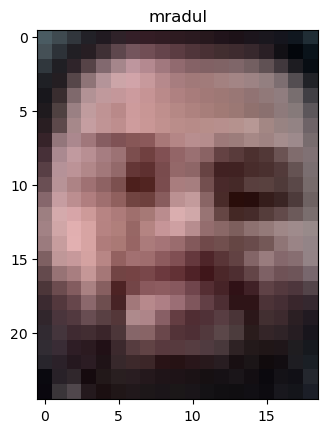

In [13]:
img_path="data/exp/WhatsApp Image 2023-12-15 at 11.03.26.jpeg"
import matplotlib.pyplot as plt
faces = RetinaFace.extract_faces(img_path = img_path, align = True)
for i in range(len(faces)):
    imgf=standard_transform(faces[i])
    imgf=model(imgf.to(device).unsqueeze(0))
    predictions=predict(imgf)
    _, pred_labels = torch.max(predictions, 1)
    name=name_from_index(pred_labels.item())
    plt.imshow(faces[i])
    plt.title(name)
    plt.show()


In [ ]:
imgf=standard_transform(faces[10])
imgf=model(imgf.to(device).unsqueeze(0))
clf.predict(imgf.cpu().detach().numpy())